<a href="https://colab.research.google.com/github/ejdam87/neural-network/blob/master/nn_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

Third-party imports

In [12]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

Standard imports

In [2]:
import random
from typing import Callable, Any

# Modules

In [3]:
class Module:
    def forward(self, x: NDArray) -> NDArray:
        raise NotImplementedError()

In [4]:
class Sequential(Module):
    def __init__(self, layers: list[Module]) -> None:
        self.layers = layers

    def forward(self, x: NDArray) -> NDArray:
        res = x
        for layer in self.layers:
            res = layer.forward(res)

        return res

## Special

In [ ]:
class FlattenLayer(Module):
    def forward(self, x: NDArray) -> NDArray:
        return x.flatten()

## Activations

In [5]:
class Activation(Module):
    def __init__(self, in_count: int) -> None:
        self.in_count = in_count

In [6]:
class StepActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return (x >= 0).astype(int)

In [7]:
class SigmoidActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return 1 / ( 1 + np.e ** (-x) )

In [8]:
class ReLUActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return (x + np.abs(x)) / 2  # same as max(0, elem) for elem in x

## Neural layers

In [9]:
class Dense(Module):
    def __init__(self,
                 in_count: int,
                 out_count: int,
                 ) -> None:

        self.in_count = in_count
        self.out_count = out_count
        self.weights = np.random.rand(self.out_count, self.in_count)
        self.biases = np.random.rand(self.out_count)

    def forward(self, x: NDArray) -> NDArray:
        return np.dot( self.weights, x ) + self.biases

    def set_weights(self, weights: NDArray) -> None:
        self.weights = weights

    def set_biases(self, biases: NDArray) -> None:
        self.biases = biases

# Training

In [ ]:
class Trainer:
    def __init__(self) -> None:
        pass

## Cost functions

In [18]:
def mse(y: NDArray, y_pred: NDArray) -> float:
    return ( (y - y_pred) ** 2 ) / len(y)

In [41]:
def bce(y: NDArray, y_pred: NDArray) -> float:
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    mean_loss = np.mean(loss)

    return mean_loss

# Showcase

Basic model creation

In [ ]:
model = Sequential( [
    Dense(3, 2),
    StepActivation(2),
    Dense(2, 1),
    SigmoidActivation(1)
] )

print( model.forward( np.array([1, 2, 3]) ) )

Activations plots on 1D inputs

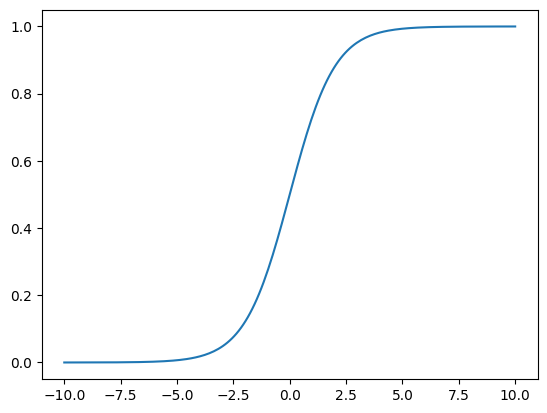

In [14]:
sigmoid = SigmoidActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)

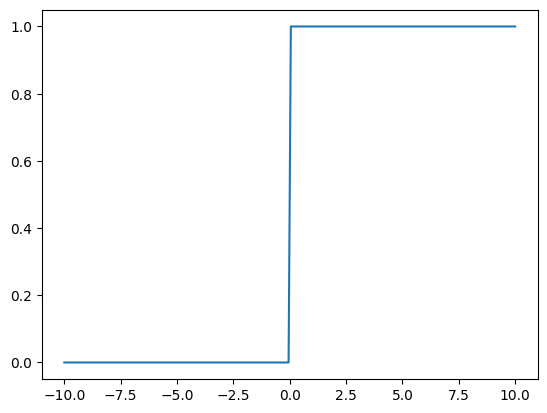

In [15]:
sigmoid = StepActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)

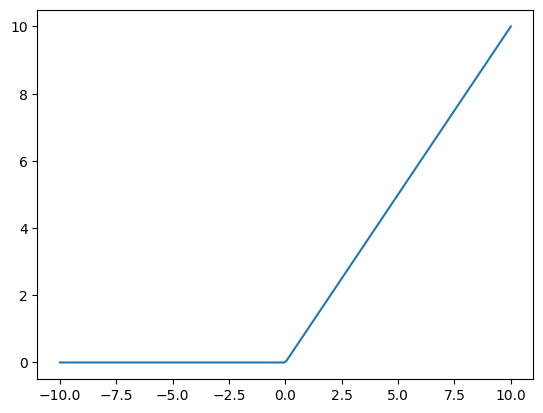

In [16]:
sigmoid = ReLUActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)